In [8]:
from game_of_life import Game_of_life
from autoencoder import ConvolutionalAutoencoder
from fullycon import CullyConnCoder

import torch.nn as nn
import torch
import tqdm
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%load_ext autoreload
%autoreload 2

SIZE=64
SIM_BATHC = 6
ADVANCED_ENEI_PARAM = 0.0002 # THE LAN REGULARIZATION PARAMETER
ENEIAN_BIASING = 0.3

def generate_batch(batch_size, size, sims=SIM_BATHC, n_plus = 1, bias=0.5):
    with torch.no_grad():
        game = Game_of_life(size)
        game.to(device)
        # random binary noise of size size x size
        prev_batch = torch.rand((batch_size, 1, size, size), device=device)
        prev_batch = (prev_batch > bias).int()
        batch = game(prev_batch)

        for i in range(sims):
            batch, prev_batch = game(batch), batch

        for i in range(1, n_plus):
            batch = game(batch)

        return prev_batch, batch


def cell_count_MSE(outputs, labels, input):
    # count of dead cells in the output
    output_alive_cells = torch.sum(input == 1, dim=(1,2,3)).float()
    alive_cells = torch.sum(outputs == 1, dim=(1,2,3)).float()
    dead_cells = torch.sum(outputs == 0, dim=(1,2,3)).float()

    log_dead_cell  = torch.mean(torch.log(alive_cells / dead_cells + 1)) / (SIZE*SIZE)
    # step_diff = torch.mean(input - outputs) # ADVANCED_ENEI_PARAM
    # lanoid_fraction = torch.mean(torch.abs(alive_cells - output_alive_cells)) / (SIZE*SIZE)

    mse_loss = nn.MSELoss()(outputs, labels)

    loss = torch.add(mse_loss, ADVANCED_ENEI_PARAM * log_dead_cell )
    return loss

def train_model(epochs, lr):
    # Use the ResNet18 when implemented
    # net = ConvolutionalAutoencoder(SIZE)
    net = CullyConnCoder(SIZE)
    net.to(device)

    # Define the loss function
    # criterion = nn.BCELoss(reduction='mean') 
    # criterion = nn.MSELoss()
    criterion = cell_count_MSE

    # criterion = nn.CrossEntropyLoss()
    # Initialize the optimizer
    optimizer = optim.Adam(net.parameters(), lr=lr)

    losses = []
    # loss_ra = 0
    for epoch in tqdm.tqdm(range(epochs)):
        # Get the inputs; Data is a tuple of (images, labels)
        inputs, labels = generate_batch(200, SIZE, SIM_BATHC, 1, ENEIAN_BIASING)

        # Clear the saved gradients of the previous iteration
        optimizer.zero_grad()

        outputs = net(inputs)
        # print(torch.min(outputs[0]), torch.max(outputs[0]))
        
        # # Calculate the loss value
        loss = criterion(outputs.float(), labels.float(), inputs.float())
        losses.append(loss.data.cpu().detach().numpy())

        # # Calculate the gradients using backpropagation
        loss.backward()
        # loss_ra += loss.data.cpu().detach().numpy()
        # # Update the weights of the network using the chosen optimizer
        
        optimizer.step()


        if (epoch % 100) == 0:
            # print(torch.sum(outputs[0] - labels[0]))
            print(loss.data.cpu().detach().numpy())
            # lr /= 1.1


    # net.eval()
    # test_bird_model(net,testloader)
    
    return net, losses

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import matplotlib.pyplot as plt
# torch.cuda.empty_cache()

net,losses = train_model(9000, 0.0005)
# prosim delaj



  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 15/9000 [00:00<01:46, 84.25it/s]

0.004420166


  1%|▏         | 120/9000 [00:00<01:04, 138.00it/s]

0.0046325685


  2%|▏         | 218/9000 [00:01<01:06, 132.62it/s]

0.004630127


  3%|▎         | 314/9000 [00:02<01:08, 127.68it/s]

0.004732666


  5%|▍         | 426/9000 [00:03<01:05, 131.52it/s]

0.0049145506


  6%|▌         | 524/9000 [00:04<01:04, 132.04it/s]

0.0044824216


  7%|▋         | 619/9000 [00:04<01:05, 128.34it/s]

0.004407959


  8%|▊         | 724/9000 [00:05<01:05, 125.72it/s]

0.0051733395


  9%|▉         | 817/9000 [00:06<01:03, 129.44it/s]

0.0048498535


 10%|█         | 922/9000 [00:07<01:03, 127.79it/s]

0.004920654


 11%|█▏        | 1015/9000 [00:07<01:01, 130.00it/s]

0.0046472168


 13%|█▎        | 1126/9000 [00:08<01:00, 130.29it/s]

0.004689941


 14%|█▎        | 1222/9000 [00:09<00:58, 132.62it/s]

0.0045043943


 15%|█▍        | 1320/9000 [00:10<00:58, 130.76it/s]

0.004494629


 16%|█▌        | 1415/9000 [00:10<00:59, 128.40it/s]

0.0045825196


 17%|█▋        | 1524/9000 [00:11<00:59, 126.21it/s]

0.0047192383


 18%|█▊        | 1616/9000 [00:12<00:57, 128.40it/s]

0.004921875


 19%|█▉        | 1724/9000 [00:13<00:56, 129.41it/s]

0.0047204588


 20%|██        | 1818/9000 [00:14<00:56, 126.23it/s]

0.004569092


 21%|██▏       | 1923/9000 [00:14<00:56, 125.88it/s]

0.0047302246


 22%|██▏       | 2016/9000 [00:15<00:55, 125.14it/s]

0.004621582


 24%|██▎       | 2123/9000 [00:16<00:54, 125.61it/s]

0.0047924803


 25%|██▍       | 2215/9000 [00:17<00:54, 124.25it/s]

0.00498291


 26%|██▌       | 2322/9000 [00:18<00:51, 128.99it/s]

0.004736328


 27%|██▋       | 2416/9000 [00:18<00:52, 126.58it/s]

0.004333496


 28%|██▊       | 2522/9000 [00:19<00:52, 122.32it/s]

0.0047143553


 29%|██▉       | 2617/9000 [00:20<00:50, 127.55it/s]

0.0049487306


 30%|███       | 2725/9000 [00:21<00:49, 127.30it/s]

0.00484375


 31%|███▏      | 2817/9000 [00:21<00:49, 123.95it/s]

0.0048364257


 32%|███▏      | 2923/9000 [00:22<00:47, 128.94it/s]

0.0045629884


 34%|███▎      | 3017/9000 [00:23<00:45, 132.49it/s]

0.004753418


 35%|███▍      | 3118/9000 [00:24<00:41, 140.22it/s]

0.004790039


 36%|███▌      | 3217/9000 [00:25<00:44, 129.38it/s]

0.0046813963


 37%|███▋      | 3323/9000 [00:25<00:44, 128.21it/s]

0.0049389647


 38%|███▊      | 3415/9000 [00:26<00:45, 121.60it/s]

0.004901123


 39%|███▉      | 3520/9000 [00:27<00:43, 126.45it/s]

0.0045825196


 40%|████      | 3624/9000 [00:28<00:43, 122.20it/s]

0.004934082


 41%|████▏     | 3723/9000 [00:29<00:47, 110.09it/s]

0.004814453


 43%|████▎     | 3826/9000 [00:30<00:41, 124.69it/s]

0.0048815915


 44%|████▎     | 3918/9000 [00:30<00:40, 124.00it/s]

0.0047424315


 45%|████▍     | 4022/9000 [00:31<00:39, 125.49it/s]

0.0046545407


 46%|████▌     | 4126/9000 [00:32<00:38, 125.47it/s]

0.004819336


 47%|████▋     | 4218/9000 [00:33<00:37, 126.62it/s]

0.0042736814


 48%|████▊     | 4322/9000 [00:33<00:36, 127.42it/s]

0.0043811034


 49%|████▉     | 4424/9000 [00:34<00:37, 122.77it/s]

0.00467041


 50%|█████     | 4515/9000 [00:35<00:37, 121.16it/s]

0.0049328613


 51%|█████▏    | 4627/9000 [00:36<00:33, 132.34it/s]

0.004926758


 53%|█████▎    | 4727/9000 [00:37<00:31, 136.75it/s]

0.0049987794


 53%|█████▎    | 4813/9000 [00:37<00:31, 133.88it/s]

0.004588623


 55%|█████▍    | 4919/9000 [00:38<00:38, 104.74it/s]

0.00493042


 56%|█████▌    | 5011/9000 [00:39<00:37, 105.88it/s]

0.0049096677


 57%|█████▋    | 5115/9000 [00:40<00:38, 101.62it/s]

0.004833984


 58%|█████▊    | 5213/9000 [00:41<00:36, 104.10it/s]

0.0047375485


 59%|█████▉    | 5319/9000 [00:42<00:37, 97.43it/s] 

0.004498291


 60%|██████    | 5418/9000 [00:43<00:35, 102.14it/s]

0.0048034666


 61%|██████▏   | 5518/9000 [00:44<00:33, 103.23it/s]

0.0048205564


 62%|██████▏   | 5620/9000 [00:45<00:32, 105.59it/s]

0.004494629


 64%|██████▎   | 5721/9000 [00:46<00:29, 109.98it/s]

0.0049023437


 65%|██████▍   | 5825/9000 [00:47<00:24, 128.79it/s]

0.004699707


 66%|██████▌   | 5925/9000 [00:48<00:22, 136.31it/s]

0.004764404


 67%|██████▋   | 6024/9000 [00:48<00:21, 137.31it/s]

0.0045373533


 68%|██████▊   | 6122/9000 [00:49<00:22, 129.68it/s]

0.0047668456


 69%|██████▉   | 6221/9000 [00:50<00:20, 134.02it/s]

0.0043481444


 70%|███████   | 6316/9000 [00:51<00:20, 130.16it/s]

0.0049658203


 71%|███████▏  | 6414/9000 [00:51<00:19, 130.79it/s]

0.0047521973


 72%|███████▏  | 6519/9000 [00:52<00:20, 118.91it/s]

0.0047875973


 74%|███████▎  | 6621/9000 [00:53<00:19, 121.92it/s]

0.0048071286


 75%|███████▍  | 6722/9000 [00:54<00:18, 122.55it/s]

0.004643555


 76%|███████▌  | 6826/9000 [00:55<00:17, 127.73it/s]

0.004859619


 77%|███████▋  | 6917/9000 [00:55<00:16, 124.17it/s]

0.004781494


 78%|███████▊  | 7020/9000 [00:56<00:15, 124.26it/s]

0.0052990722


 79%|███████▉  | 7121/9000 [00:57<00:16, 113.51it/s]

0.0045251464


 80%|████████  | 7219/9000 [00:58<00:14, 118.94it/s]

0.0048266603


 81%|████████▏ | 7315/9000 [00:59<00:14, 113.50it/s]

0.004888916


 82%|████████▏ | 7420/9000 [01:00<00:12, 122.17it/s]

0.0048620603


 84%|████████▎ | 7524/9000 [01:01<00:12, 120.13it/s]

0.004893799


 85%|████████▍ | 7621/9000 [01:01<00:11, 124.88it/s]

0.0047216797


 86%|████████▌ | 7717/9000 [01:02<00:10, 125.74it/s]

0.0046472168


 87%|████████▋ | 7824/9000 [01:03<00:09, 125.68it/s]

0.004897461


 88%|████████▊ | 7921/9000 [01:04<00:08, 132.92it/s]

0.0048742676


 89%|████████▉ | 8018/9000 [01:04<00:07, 130.96it/s]

0.0049560545


 90%|█████████ | 8117/9000 [01:05<00:06, 134.83it/s]

0.004527588


 91%|█████████▏| 8216/9000 [01:06<00:05, 132.06it/s]

0.004489746


 92%|█████████▏| 8316/9000 [01:07<00:05, 127.88it/s]

0.004699707


 94%|█████████▎| 8422/9000 [01:08<00:04, 122.66it/s]

0.0048046876


 95%|█████████▍| 8517/9000 [01:08<00:03, 132.00it/s]

0.004338379


 96%|█████████▌| 8616/9000 [01:09<00:02, 133.97it/s]

0.004456787


 97%|█████████▋| 8728/9000 [01:10<00:02, 134.22it/s]

0.0046643065


 98%|█████████▊| 8828/9000 [01:11<00:01, 136.57it/s]

0.004764404


 99%|█████████▉| 8927/9000 [01:11<00:00, 135.44it/s]

0.004732666


100%|██████████| 9000/9000 [01:12<00:00, 124.25it/s]


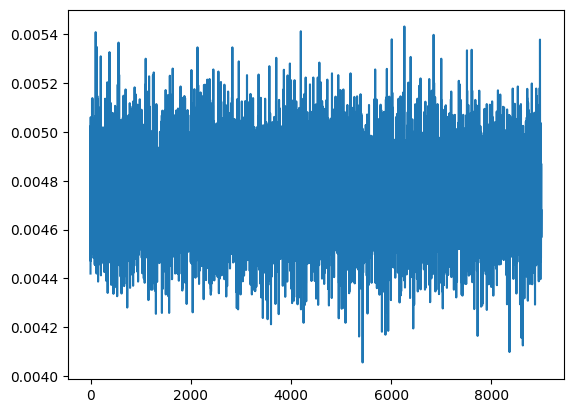

In [10]:
plt.plot(losses)
plt.show()

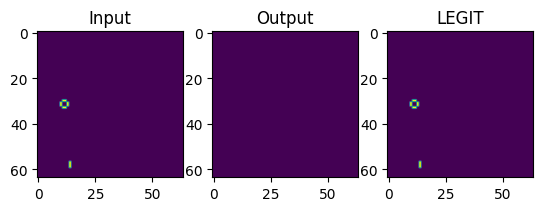

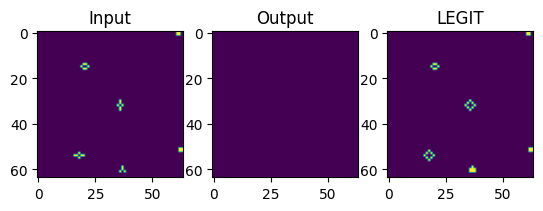

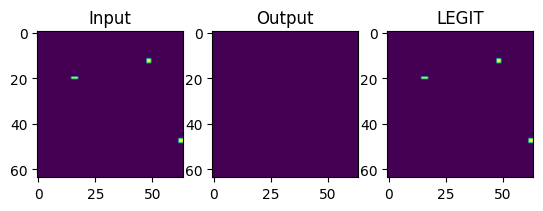

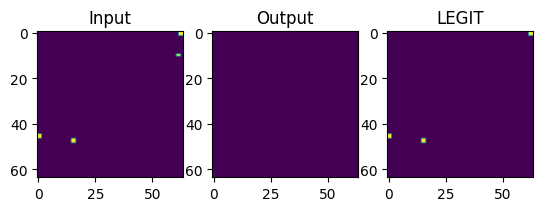

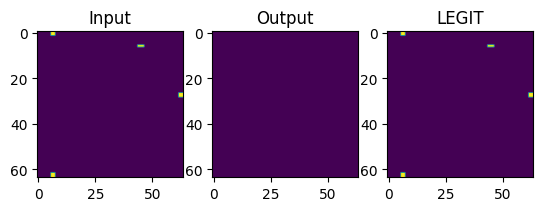

In [11]:
#RANDOM TRIES
batch, next= generate_batch(5, SIZE, SIM_BATHC, 2, ENEIAN_BIASING)
out = net(batch).cpu().detach().numpy()
out = out > 0.5
ba = batch.cpu().detach().numpy()
ne = next.cpu().detach().numpy()

for i in range(5):
    ins = ba[i][0]
    res = out[i][0]
    nes = ne[i][0]
    fix, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(ins)
    ax1.set_title("Input")
    ax2.imshow(res)
    ax2.set_title("Output")
    ax3.imshow(nes)
    ax3.set_title("LEGIT")


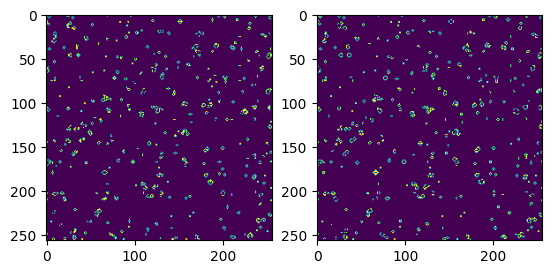

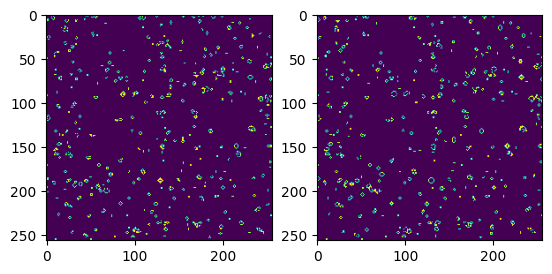

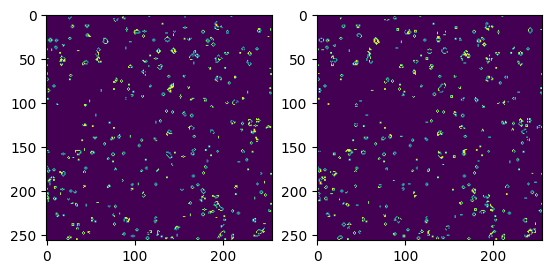

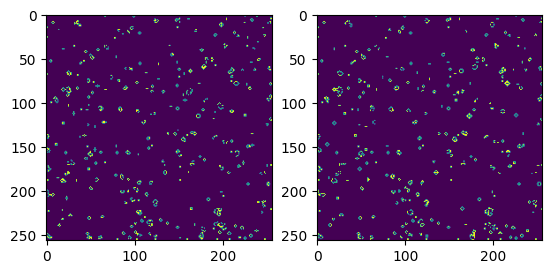

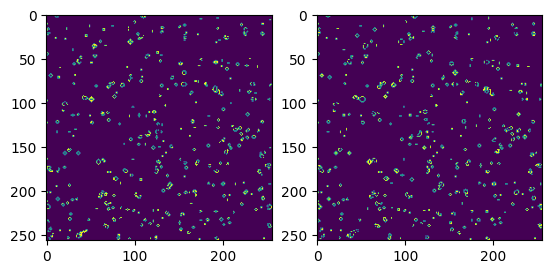

In [6]:
L = 5
out = generate_batch(L, SIZE, SIM_BATHC, 1, 0.3)
for i in range(L):
    ins = out[0][i][0].cpu().detach().numpy()
    res = out[1][i][0].cpu().detach().numpy()
    fix, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(ins)
    ax2.imshow(res)

In [12]:
import pygame
SIZE = 256
GAME_SIZE = 4
WAIT = 20

calc_wait =round( WAIT / SIZE**0.5 ) 

def get_new(previous:torch.Tensor, net:torch.nn.Module):
    with torch.no_grad():
        tensor = net(previous)
        return tensor, tensor.squeeze().cpu().detach().numpy() > 0.5

def display_grid(grid, screen):
    size = len(grid)
    cell_size = GAME_SIZE
    for i in range(size):
        for j in range(size):
            if grid[i][j] == 1:
                pygame.draw.rect(screen, (255, 255, 255), (i*cell_size, j*cell_size, cell_size, cell_size))
            else:
                pygame.draw.rect(screen, (0, 0, 0), (i*cell_size, j*cell_size, cell_size, cell_size))
    pygame.display.flip()

first, second = generate_batch(1, SIZE, 15, 1, ENEIAN_BIASING)
tensor, grid = get_new(first, net)
pygame.init()
screen = pygame.display.set_mode((SIZE*GAME_SIZE, SIZE*GAME_SIZE))

running = True
i = 0
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        if event.type == pygame.KEYDOWN:
            if event.key == pygame.K_SPACE:
                running = False
        # r resetes game with new random grid
        if event.type == pygame.KEYDOWN:
            if event.key == pygame.K_r:
                first, second = generate_batch(1, SIZE, 15, 1,ENEIAN_BIASING)
                tensor, grid = get_new(first, net)
        # plt.imshow(grid) and save it when S is pressed
        if event.type == pygame.KEYDOWN:
            if event.key == pygame.K_s:
                plt.imshow(grid, cmap='gray')
                plt.savefig(f"grid_{i}.png")
    tensor, grid = get_new(tensor, net)
    display_grid(grid, screen)
    pygame.time.wait(calc_wait)
    # if(tensor.sum() == 0 or tensor.sum() == SIZE*SIZE):
    #     running = False
    i += 1

pygame.quit()

In [67]:
pygame.quit()